In [56]:
import numpy as np
from sklearn.metrics import f1_score

'''
Author: Damiano Pasquini
email: damiano23@ru.is
'''

# imports and configs
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from seaborn import heatmap

path = './dataset'
classifiers = [MultinomialNB(), KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]

In [57]:
def read_data(path):
    """
    Reads the data from the csv file and returns a pandas dataframe
    :param path: path to the csv file
    :return: pandas dataframe
    """
    with open(path+"/api_trace.csv", 'r') as data_file:
        data = [str(line.split(',')) for line in data_file]
    with open(path+"/apt_trace_labels.txt", 'r') as label_file:
        labels = [line for line in label_file]
    return pd.DataFrame({'traces':data,'labels':labels})

In [58]:
def preprocess(df):
    """
    Preprocess the dataframe and returns the X and y for the training and test set
    :param df: pandas dataframe
    :return: X_train, X_test, y_train, y_test
    """
    df.drop_duplicates(subset=['traces'], inplace=True)
    df.replace([np.inf], np.finfo(np.float32).max, inplace=True) # Replace inf values with max of float 32
    df.replace([-np.inf], -np.finfo(np.float32).min, inplace=True) # Replace inf values with min value of float 32
    df.fillna(0, inplace=True) # Replace all NaN values with 0
    X_train, X_test, y_train, y_test = train_test_split(df['traces'], df['labels'], test_size=0.3, random_state=42)
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train.toarray())
    X_test = scaler.transform(X_test.toarray())
    return X_train, X_test, y_train, y_test

In [59]:
def train_classifier(X_train, X_test, y_train, y_test, classifier = MultinomialNB()):
    """
    Trains the classifier and prints the heatmap of the confusion matrix
    :param X_train: training set
    :param X_test: test set
    :param y_train: training labels
    :param y_test: test labels
    :param classifier: classifier to use
    :return: None
    """
    cf = classifier
    if classifier == LogisticRegression():
        cf = LogisticRegression(max_iter=1000)
    cf.fit(X_train, y_train)
    y_pred = cf.predict(X_test)
    matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    heatmap(matrix, annot=True)
    f1score = f1_score(y_test, y_pred, average='weighted')
    print('F1 Score: '+str(f1score))
    plt.show()
    return

In [60]:
print('Preprocessing...')
X_train, X_test, y_train, y_test = preprocess(read_data(path))

Preprocessing...


Training classifier:  MultinomialNB()
F1 Score: 0.30399494071901517


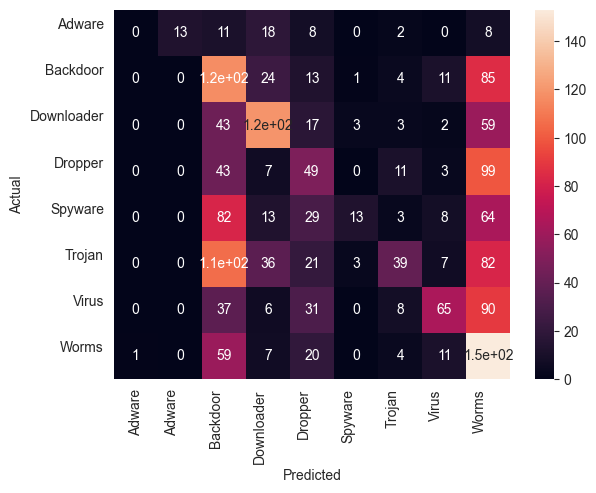

Training classifier:  KNeighborsClassifier()
F1 Score: 0.41395390281195277


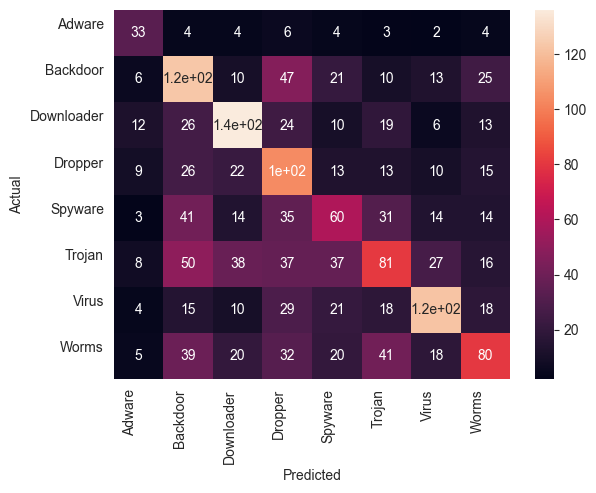

Training classifier:  LogisticRegression()


C:\Users\pasqu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score: 0.2939364863894123


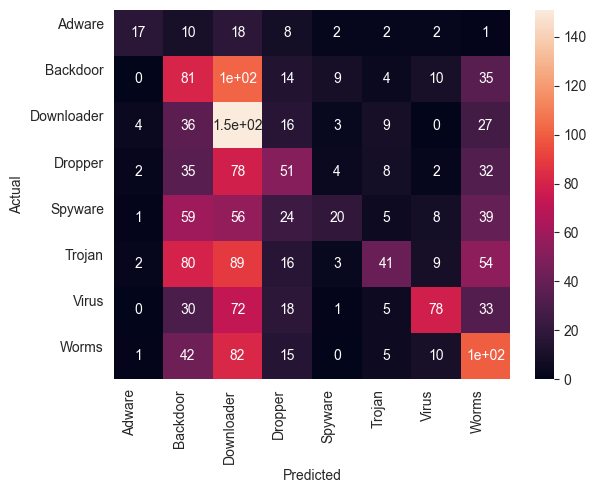

Training classifier:  DecisionTreeClassifier()
F1 Score: 0.518656771139174


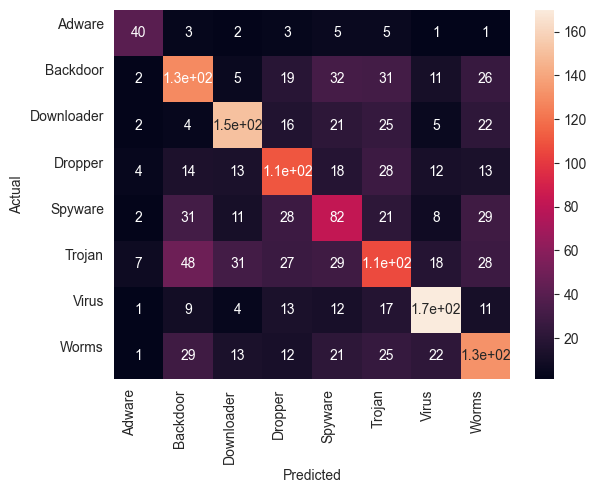

Training classifier:  RandomForestClassifier()
F1 Score: 0.6107013933859076


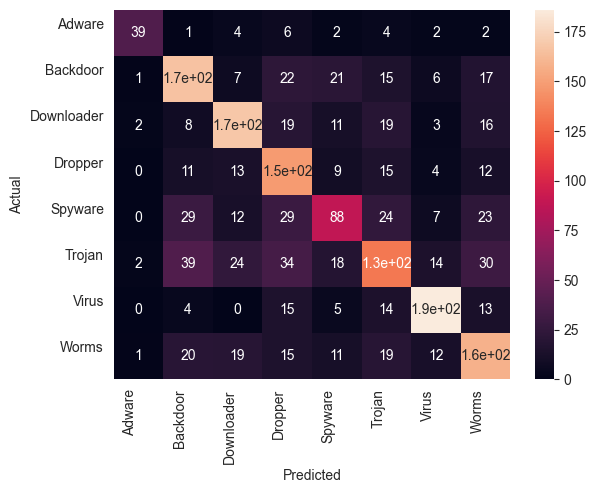

In [61]:
for classifier in classifiers:
    print('Training classifier: ', classifier)
    train_classifier(X_train, X_test, y_train, y_test, classifier = classifier)